<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #8: Agrupación de textos
`Fecha de entrega: Abril 29, 2021. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [1]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

!pip install plotly
!pip install cufflinks
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [4]:
# Cargar datos
path = 'reviews_vidjew_es (1).csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [5]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

###  `[10 pts]` Punto 2: Método del codo para determinar $K$

In [6]:
tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect.get_feature_names())

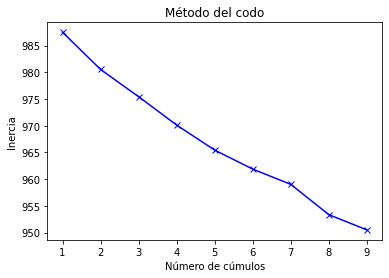

In [9]:
ks = []
kinertia = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    ks.append(k)
    kinertia.append(kmeans.inertia_)
    
plt.xlabel("Número de cúmulos"); 
plt.ylabel("Inercia");
plt.title('Método del codo')
plt.plot(ks,kinertia, 'bx-');

###  `[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [11]:
k = 3
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)
nbrs = NearestNeighbors(n_neighbors=3, metric="euclidean").fit(tfidf_matrix.values)

###  `[15 pts]` Punto 4: Interpretación de los clusters

In [15]:
data['cluster'] = model.labels_
clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)
 
centroides = model.cluster_centers_
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names()
 
print(f"CLUSTERS:\n")

for i in range(k):
    print(f"Cluster :{i}")
    print(f"{clust_cnt[i]} textos ({clust_cnt_pct[i]:.2%} de los datos)")
    print(f"Terminos: ", end=" ")
    for idx in order_centroids[i, :15]:
        print(f"{terms[idx]}", end=" ")
    print("\n")
    print(f"REPRESENTATIVE COMMENTS")
    for texto in data.iloc[nbrs.kneighbors([centroides[i]])[1][0]]['review_body'].values:
        print(f"* {texto}")
    print("\n")

CLUSTERS:

Cluster :0
734 textos (73.40% de los datos)
Terminos:  bien juego bonito si regalo mas foto llegado bonitos mando queda buen bastante tiempo aunque 

REPRESENTATIVE COMMENTS
* Bonito fue para un regalo y bien
* Esta bien,fue un regalo
* Acerté con el regalo, lo recomiendo queda muy chulo. El tamaño del colgante está bien justo como sale en la foto. Viene con una cadena que está bien para el precio.


Cluster :1
152 textos (15.20% de los datos)
Terminos:  producto perfecto llegó bien buen llegado tiempo gracias tamaño solo sido llego día si nunca 

REPRESENTATIVE COMMENTS
* El producto en buen estado. Perfecto.
* Todo en perfecto estado
* Llegó a tiempo y en perfecto estado


Cluster :2
114 textos (11.40% de los datos)
Terminos:  precio calidad buena bien pedir buen puede mala compra relación cumple regalo bueno bonitos cadena 

REPRESENTATIVE COMMENTS
* Calidad precio buena
* Calidad precio muy buena
* Calidad precio buena




###  `[BONUS: 3 pts]` Visualización usando PCA

In [49]:
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = data.cluster.values
result['texto'] = data.review_body.apply(lambda val: val[:140])

cols = data['cluster'].map(colorsIdx)

trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color='MediumPurple')) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Comparación

### `[BONUS 15 pts (validos para cualquier tarea)]` 
### Hacer predicción para estas dos frases de los dos modelos (clasificación y $k$-means)

In [35]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=28)
#train, test 
print(f"El conjunto de datos de entrenamiento esta compuesto por {train.shape[0]} registros")
print(f"El conjunto de datos de prueba esta compuesto por {test.shape[0]} registros")

El conjunto de datos de entrenamiento esta compuesto por 800 registros
El conjunto de datos de prueba esta compuesto por 200 registros


In [36]:
X_train = tfidf_vect.fit_transform(train.review_body.values)
y_train = train.product_category.values
 
X_test = tfidf_vect.transform(test.review_body.values)
y_test = test.product_category.values

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
nb = MultinomialNB()
svm = LinearSVC(class_weight='balanced')

In [38]:
nb.fit(X_train, y_train)
svm.fit(X_train, y_train);

In [41]:
from sklearn.metrics import accuracy_score, f1_score
y_pred_nb = nb.predict(X_test)
y_pred_svm = svm.predict(X_test)

#Exactitud:
print(f"Naive Bayes: {accuracy_score(y_test, y_pred_nb):>15.2f}")
print(f"SVM: {accuracy_score(y_test, y_pred_svm):>23.2f}")

Naive Bayes:            0.84
SVM:                    0.84


In [43]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]
testTransclas = tfidf_vect.transform(test)
testTransagrup = tfidf_vect.transform(test)


In [45]:
nb.predict(testTransclas)

array(['video_games', 'jewelry'], dtype='<U11')

### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
La estructura de k-Means es un array lo cual nos permite acceder de forma rapido a los datos pues conocemos su ubicación
- ¿Qué diferencia notó entre los resultados del taller pasado y este?
Tal vez el modelo de Bayes es más practico que K-means, sin embargo todo depende de lo que queremos para responder nuestra pregunta de negocio
- ¿Alguna otra observación?